# Metadata

```
Course:   DS 5001
Module:   10 Lab
Topic:    Class to compute sentiment following Gallagher, et al.
Author:   R.C. Alvarado
```
Purpose:  We compute sentiment as prescribed by <a href="https://epjdatascience.springeropen.com/articles/10.1140/epjds/s13688-021-00260-3">Gallagher, et al. 2021.</a>

# Set Up

In [1]:
data_home = '../data'
data_prefix = 'novels'

In [29]:
salex_csv = f'{data_home}/salex/salex_combo.csv'

In [4]:
emo_cols = "anger anticipation disgust fear joy sadness surprise trust polarity".split()

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly_express as px
from IPython.display import display, HTML

In [6]:
sns.set()

# Get Lexicon

In [8]:
SALEX = pd.read_csv('../data/salex/salex_combo.csv').set_index('term_str')
SALEX = SALEX[~SALEX.index.duplicated()] # There are 2 instances of 'naive' for some reason
assert SALEX.index.is_unique

In [9]:
SALEX

,nrc_anger,nrc_anticipation,nrc_disgust,nrc_fear,nrc_joy,nrc_negative,nrc_positive,nrc_sadness,nrc_surprise,nrc_trust,nrc_polarity,bing_negative,bing_positive,bing_sentiment,syu_sentiment,gi_sentiment,labmt_happiness,labmt_z
term_str,,,,,,,,,,,,,,,,,,
#epicpetwars,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.54,-1.769874
#fact,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.30,-1.069351
#fail,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.62,-3.539615
#fb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.12,-1.235265
#ff,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.64,-1.677700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zone,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.32,-1.050917
zoo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.62,0.147345
zou,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.69,-1.631613


In [10]:
nrc_cols = [col for col in SALEX.columns if 'nrc_' in col]

In [11]:
nrc_cols

['nrc_anger',
 'nrc_anticipation',
 'nrc_disgust',
 'nrc_fear',
 'nrc_joy',
 'nrc_negative',
 'nrc_positive',
 'nrc_sadness',
 'nrc_surprise',
 'nrc_trust',
 'nrc_polarity']

In [12]:
# SALEX.join(SALEX_ALL.sents)

# Get Novels

In [ ]:
OHCO = ['book_id', 'chap_id', 'para_num', 'sent_num', 'token_num']

In [30]:
TOKENS = pd.read_csv(f'{data_home}/{data_prefix}/{data_prefix}-CORPUS.csv').set_index(OHCO).sort_index()
# LIB = pd.read_csv(f"{data_home}/{data_prefix}/{data_prefix}-LIB.csv").set_index('book_id').sort_index()
# LIB['label'] = LIB.apply(lambda x: f"{x.author_id}: {x.name} ({x.genre_id})", 1)

In [14]:
TOKENS

pos term_str
book_id    chap_id para_num sent_num token_num              
adventures 1       0        1        0           DT        a
                                     1          NNP  scandal
                                     2          NNP       in
                                     3          NNP  bohemia
                   1        0        0           NN        i
...                                             ...      ...
usher      1       47       4        78          IN       of
                                     79          DT      the
                                     80          NN    house
                                     81          IN       of
                                     82         NNP    usher

[1500417 rows x 2 columns]

# Define Classes

In [15]:
import pandas as pd

class Sentiment():
    
    ohco_level:int = 1
    
    def __init__(self, TOKENS:pd.DataFrame, SALEX:pd.DataFrame):
        self.TOKENS = TOKENS
        self.OHCO = TOKENS.index.names
        self.SALEX = SALEX
        self._get_vocab()
        print(f"Current OHCO level = {self.ohco_level}, {self.OHCO[:self.ohco_level]}.")
        
    def main(self):
        self._get_bow()
        self._compute_sents()
        print("Done")
    
    # Consider putting in another class, possibly parent, since it is 
    # independent of BOW.
    def _get_vocab(self):
        """
        Extract VOCAB from TOKENS and compute corpus sentiment.
        """
        print("Extracting VOCAB")
        VOCAB = self.TOKENS.value_counts('term_str').to_frame('n').sort_index()
        VOCAB['p'] = VOCAB.n / VOCAB.n.sum()
        SENTS = (VOCAB.p * self.SALEX.T).T # GLOBAL SENTIMENT
        self.VOCAB = pd.concat([VOCAB, SENTS], keys=['stats','sents'], axis=1).loc[VOCAB.index]
        
    def _get_bow(self):
        """
        Extract BOW from TOKENS.
        """
        print("Extracting BOW")
        bag = self.TOKENS.index.names[:self.ohco_level]
        self.BOW = self.TOKENS.value_counts(bag + ['term_str']).to_frame('n').sort_index()
        # self.BOW['tf'] = (self.BOW.unstack().T / self.BOW.unstack().T.sum()).T.stack()
        self.BOW['tf'] = self.BOW.groupby(bag).n.apply(lambda x: x / x.sum())

    def _compute_sents(self):
        """
        Create a DOC tables of stats, terms, and sentiments from BOW and SALEX.
        """
        print("Computing sentiment")
        sent_cols = self.SALEX.columns
        bag = self.BOW.index.names[:-1]
        DOC_STATS = self.BOW.groupby(bag).n.sum().to_frame('n')   
        DOC_TERMS = self.BOW.tf.unstack() 
        DOC_TERMS2 = self.BOW.n.unstack() 
        DOC_SENTS = pd.DataFrame(index=DOC_STATS.index, columns=sent_cols)
        DOC_SENTS2 = pd.DataFrame(index=DOC_STATS.index, columns=sent_cols)
        for col in sent_cols:
            print(col, end=' ')
            DOC_SENTS[col] = (DOC_TERMS * self.SALEX[col]).sum(1) # LOCAL SENTIMENT   
            DOC_SENTS2[col] = (DOC_TERMS2 * self.SALEX[col]).mean(1)
        print()
        print("Creating DOC")
        self.DOC = pd.concat([DOC_STATS, DOC_SENTS, DOC_SENTS2, DOC_TERMS, DOC_TERMS2], axis=1, 
                             keys=['stats', 'sents', 'sents2', 'terms', 'terms2'])                

In [32]:
# Maybe put in another class
def show_heatmap(X, height=600):
    fig = px.imshow(X, color_continuous_scale='Spectral', height=height)
    fig.update_layout(coloraxis_showscale=False)
    fig.update_xaxes(side="top", tickangle=45)
    fig.show()

# By BOOK

In [16]:
book_sent = Sentiment(TOKENS, SALEX)

Extracting VOCAB
Current OHCO level = 1, ['book_id'].


In [17]:
book_sent.VOCAB.sents[nrc_cols].dropna().sample(10).style.background_gradient(axis=None, cmap='GnBu')

,nrc_anger,nrc_anticipation,nrc_disgust,nrc_fear,nrc_joy,nrc_negative,nrc_positive,nrc_sadness,nrc_surprise,nrc_trust,nrc_polarity
term_str,,,,,,,,,,,
perplexity,0.000000,0.000000,0.000000,0.000000,0.000000,0.000020,0.000000,0.000020,0.000000,0.000000,-0.000020
doomed,0.000000,0.000000,0.000000,0.000017,0.000000,0.000017,0.000000,0.000017,0.000000,0.000000,-0.000017
debt,0.000000,0.000000,0.000000,0.000000,0.000000,0.000012,0.000000,0.000012,0.000000,0.000000,-0.000012
badly,0.000000,0.000000,0.000000,0.000000,0.000000,0.000019,0.000000,0.000019,0.000000,0.000000,-0.000019
cautiously,0.000000,0.000000,0.000000,0.000020,0.000000,0.000000,0.000020,0.000000,0.000000,0.000000,0.000020
surly,0.000003,0.000000,0.000003,0.000000,0.000000,0.000003,0.000000,0.000000,0.000000,0.000000,-0.000003
suffocating,0.000000,0.000000,0.000003,0.000003,0.000000,0.000003,0.000000,0.000003,0.000000,0.000000,-0.000003
liquor,0.000020,0.000000,0.000000,0.000000,0.000020,0.000020,0.000000,0.000020,0.000000,0.000000,-0.000020
constrain,0.000000,0.000000,0.000000,0.000001,0.000000,0.000001,0.000000,0.000000,0.000000,0.000000,-0.000001


In [18]:
book_sent.ohco_level = 1

In [19]:
book_sent.main()

Extracting BOW
Computing sentiment
nrc_anger nrc_anticipation nrc_disgust nrc_fear nrc_joy nrc_negative nrc_positive nrc_sadness nrc_surprise nrc_trust nrc_polarity bing_negative bing_positive bing_sentiment syu_sentiment gi_sentiment labmt_happiness labmt_z 
Creating DOC
Done


In [20]:
# book_sent.DOC.sents[nrc_cols].style.background_gradient(cmap='Spectral', axis=None)

In [21]:
# book_sent.DOC.sents2[nrc_cols].style.background_gradient(cmap='GnBu', axis=None)

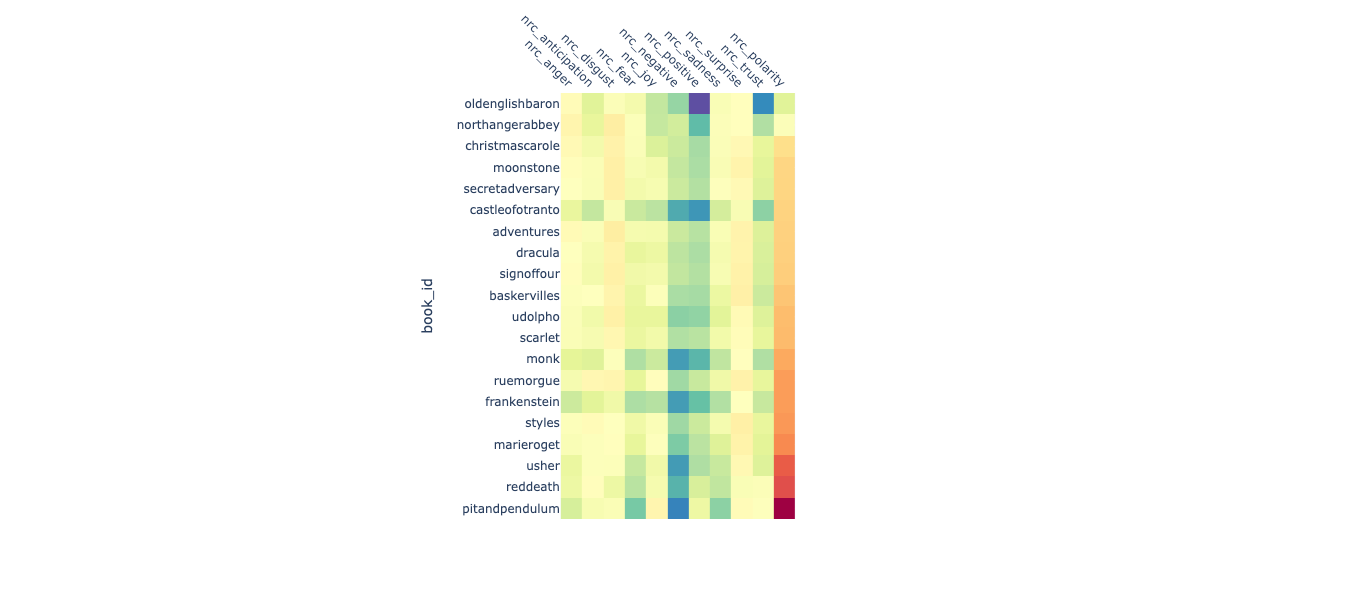

In [33]:
show_heatmap(book_sent.DOC.sents[nrc_cols].sort_values('nrc_polarity', ascending=False))

In [137]:
# show_heatmap(book_sent.DOC.sents2[nrc_cols].sort_values('nrc_polarity', ascending=False))

In [24]:
px.bar(book_sent.DOC.sents[nrc_cols].reset_index().sort_values('nrc_polarity'), nrc_cols, 'book_id', orientation='h', height=1000)

In [138]:
# px.bar(book_sent.DOC.sents2[nrc_cols].reset_index().sort_values('nrc_polarity'), nrc_cols, 'book_id', orientation='h', height=1000)

In [26]:
# pd.concat([book_sent.DOC.stats.n, book_sent.DOC.sents.sum(1)], axis=1, keys=['n','total_sent']).plot.scatter('n','total_sent')

**Are some books more sentimental than others?**

In [27]:
px.bar(book_sent.DOC.sents.sum(1).sort_values(), orientation='h', width=600, height=500)

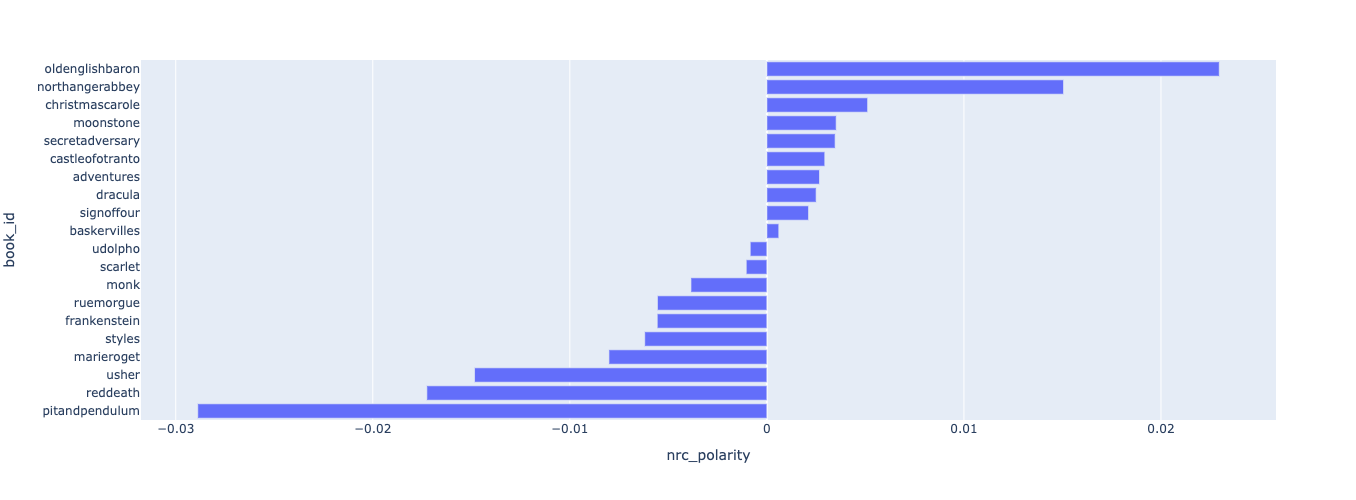

In [38]:
px.bar(book_sent.DOC.sents[nrc_cols].reset_index().sort_values('nrc_polarity'), 'nrc_polarity', 'book_id', 
       orientation='h', height=500, width=600)

In [139]:
# px.bar(book_sent.DOC.sents2[nrc_cols].reset_index().sort_values('nrc_polarity'), 'nrc_polarity', 'book_id', 
#        orientation='h', height=500, width=600)

# By CHAP

In [44]:
chap_sent = Sentiment(TOKENS, SALEX)

Extracting VOCAB
Current OHCO level = 1, ['book_id'].


In [45]:
chap_sent.ohco_level = 2

In [46]:
chap_sent.main()

Extracting BOW
Computing sentiment
nrc_anger nrc_anticipation nrc_disgust nrc_fear nrc_joy nrc_negative nrc_positive nrc_sadness nrc_surprise nrc_trust nrc_polarity bing_negative bing_positive bing_sentiment syu_sentiment gi_sentiment labmt_happiness labmt_z 
Creating DOC
Done


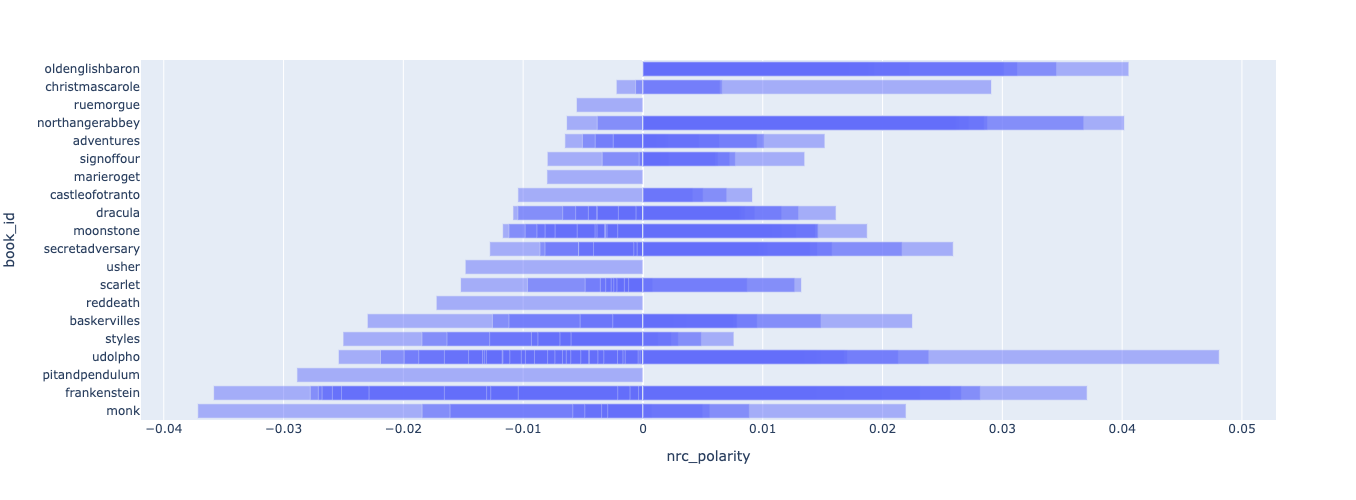

In [47]:
px.bar(chap_sent.DOC.sents.reset_index().sort_values('nrc_polarity'), 'nrc_polarity', 'book_id', 
       hover_data=['chap_id'], barmode='overlay',
       orientation='h', height=500, width=600)

In [140]:
# px.bar(chap_sent.DOC.sents2.reset_index().sort_values('nrc_polarity'), 'nrc_polarity', 'book_id', 
#        hover_data=['chap_id'], barmode='overlay',
#        orientation='h', height=500, width=600)

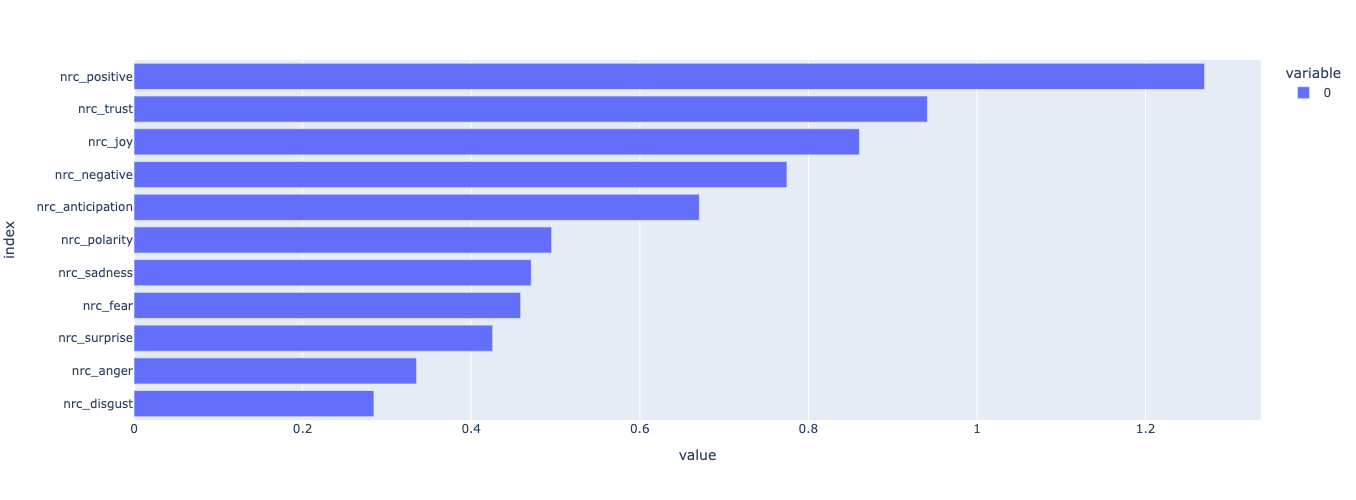

In [49]:
px.bar(chap_sent.DOC.sents[nrc_cols].T.northangerabbey.sum(1).sort_values(), orientation='h', height=500, width=600)

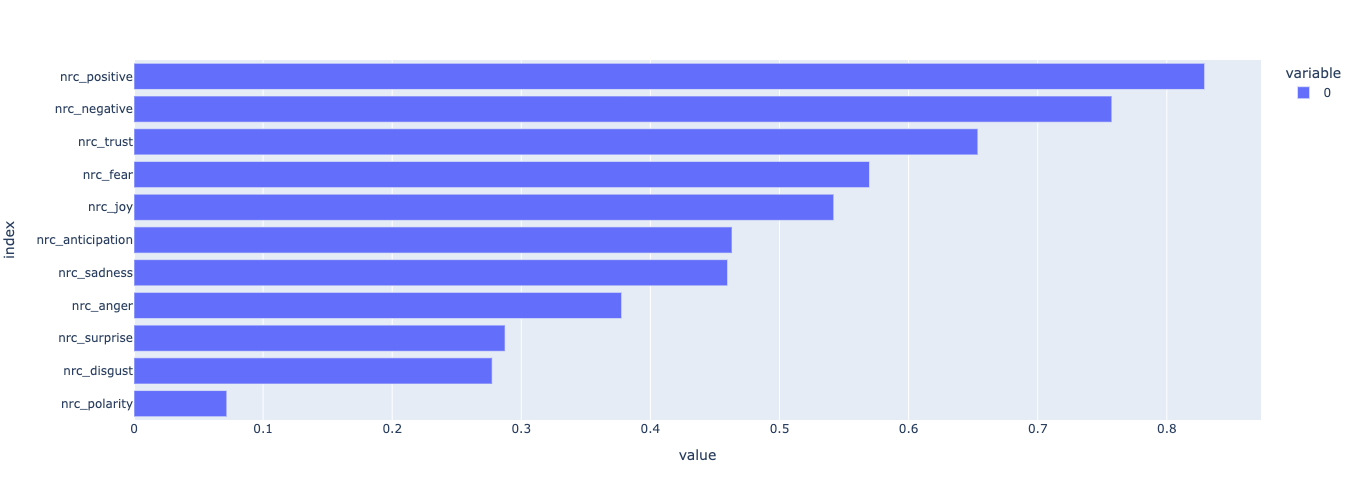

In [50]:
px.bar(chap_sent.DOC.sents[nrc_cols].T.dracula.sum(1).sort_values(), orientation='h', height=500, width=600)

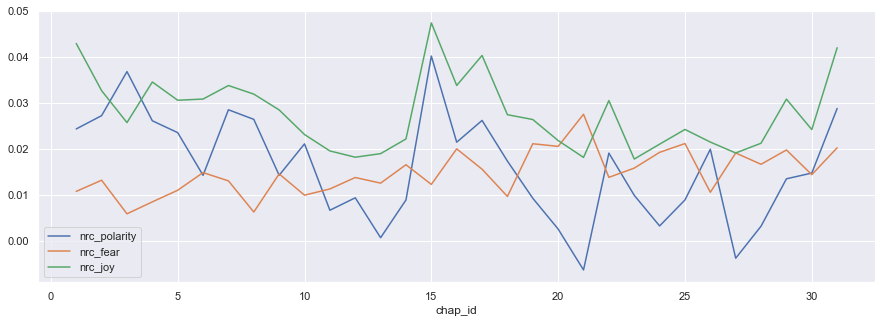

In [51]:
chap_sent.DOC.sents.T.northangerabbey.T[['nrc_polarity','nrc_fear','nrc_joy']].plot(figsize=(15,5));

In [141]:
# chap_sent.DOC.sents2.T.northangerabbey.T[['nrc_polarity','nrc_fear','nrc_joy']].plot(figsize=(15,5));

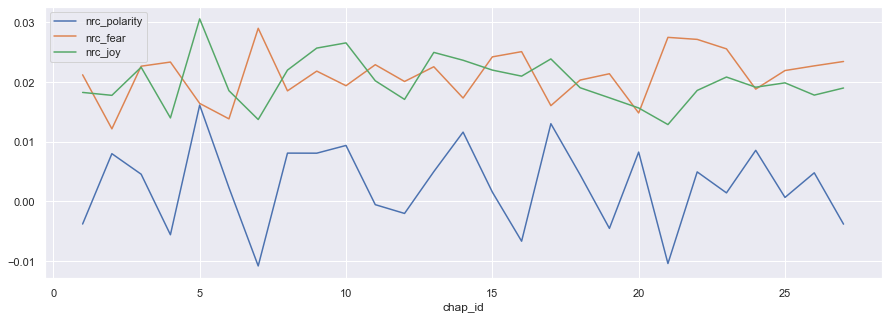

In [142]:
chap_sent.DOC.sents.T.dracula.T[['nrc_polarity','nrc_fear','nrc_joy']].plot(figsize=(15,5));
# chap_sent.DOC.sents2.T.dracula.T[['nrc_polarity','nrc_fear','nrc_joy']].plot(figsize=(15,5));

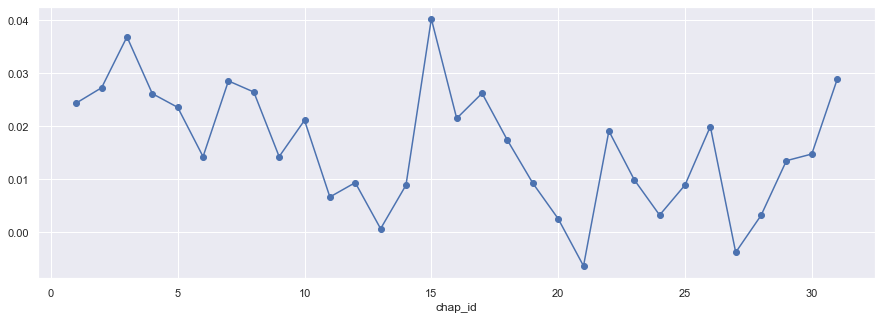

In [54]:
chap_sent.DOC.sents.T.northangerabbey.T.nrc_polarity.plot(figsize=(15,5), style='o-');

In [143]:
# chap_sent.DOC.sents2.T.northangerabbey.T.nrc_polarity.plot(figsize=(15,5), style='o-');

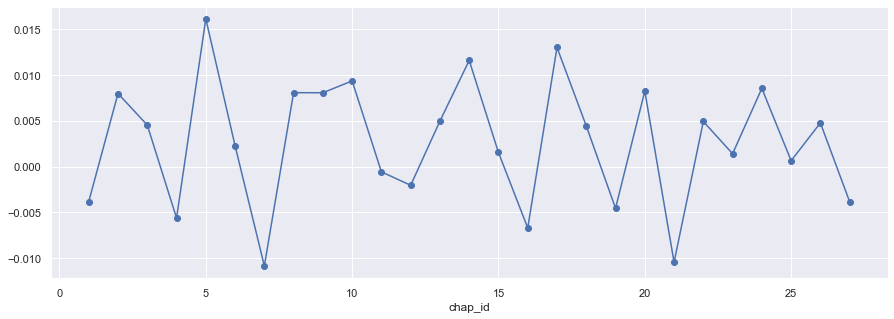

In [56]:
chap_sent.DOC.sents.T.dracula.T.nrc_polarity.plot(figsize=(15,5), style='o-');

In [144]:
# chap_sent.DOC.sents2.T.dracula.T.nrc_polarity.plot(figsize=(15,5), style='o-');

In [58]:
# chap_sent.DOC.sents[nrc_cols].T.northangerabbey.T.style.background_gradient(cmap='Spectral', axis=None)

In [59]:
# chap_sent.DOC.sents[nrc_cols].T.dracula.T.style.background_gradient(cmap='Spectral', axis=None)

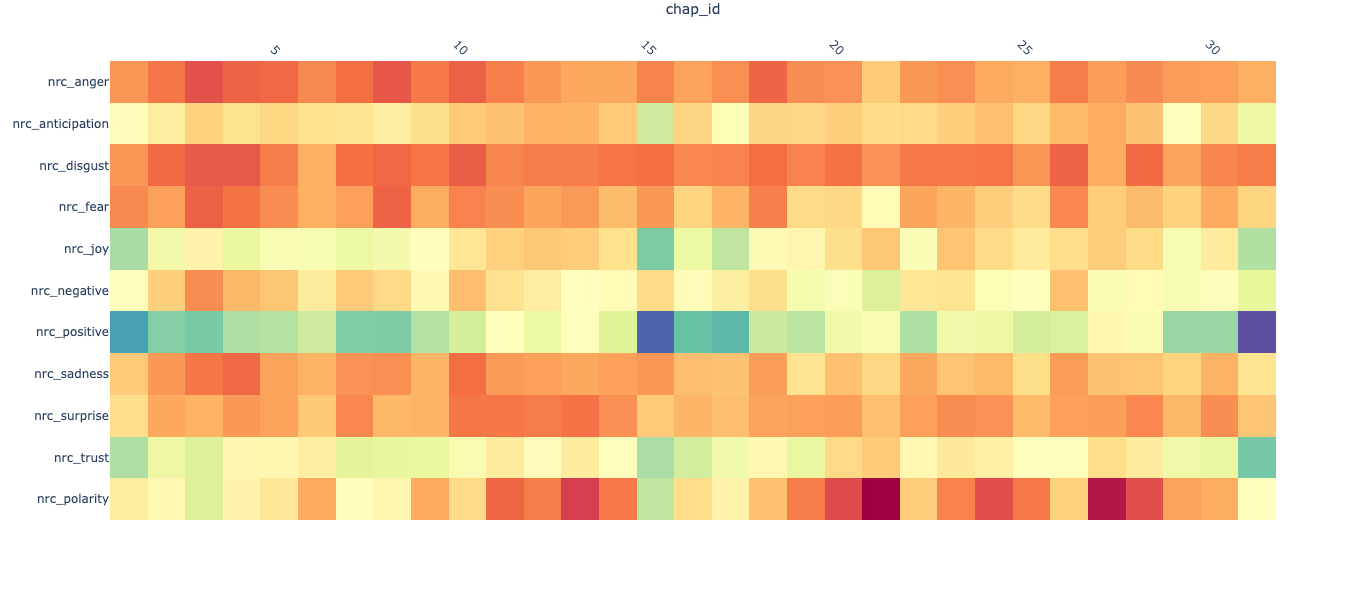

In [64]:
chap_sent.show_heatmap(chap_sent.DOC.sents[nrc_cols].T.northangerabbey)

In [145]:
# chap_sent.show_heatmap(chap_sent.DOC.sents2[nrc_cols].T.northangerabbey)

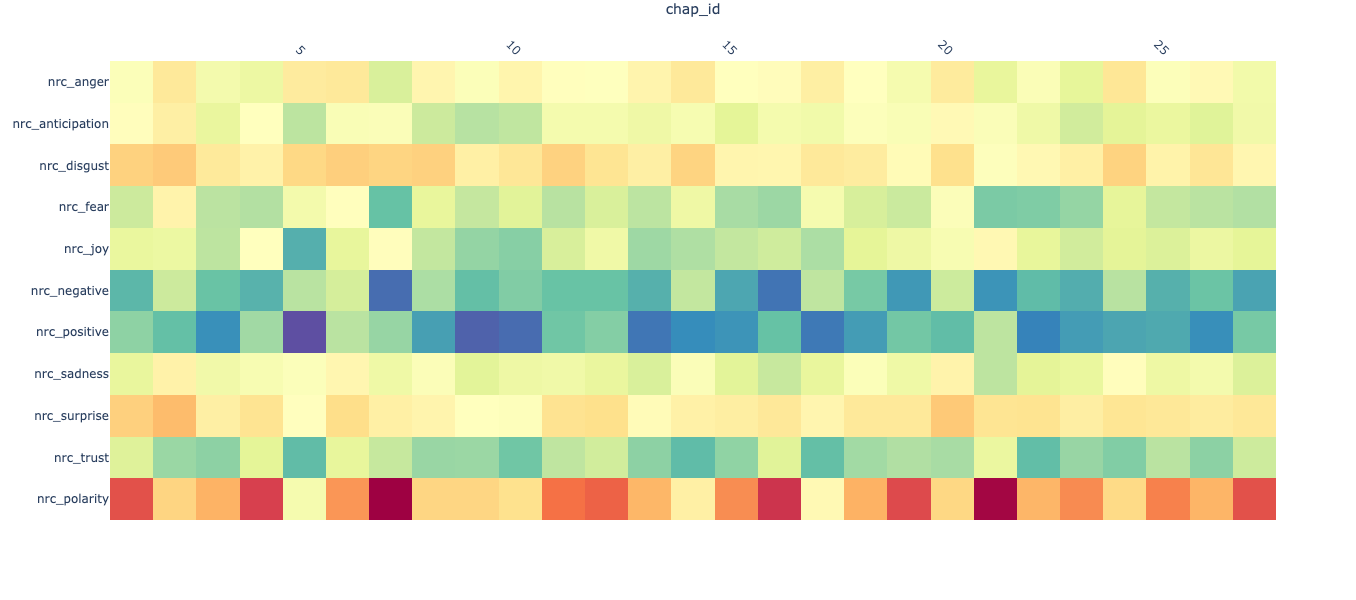

In [66]:
chap_sent.show_heatmap(chap_sent.DOC.sents[nrc_cols].T.dracula)

In [146]:
# chap_sent.show_heatmap(chap_sent.DOC.sents2[nrc_cols].T.dracula)

# Compare

In [147]:
def compare_docs(sent_model, doc_list, sent_col='polarity', w=5, cuts=25):
    dfs = {}
    for doc_id in doc_list:    
        df = sent_model.DOC.sents.loc[doc_id].reset_index(drop=True).reset_index().rename(columns=dict(index='seq'))
        df['cut'] = pd.cut(df.seq, cuts)
        dfs[doc_id] = df.groupby('cut')[sent_col].mean().reset_index(drop=True)
    X = pd.concat(dfs.values(), axis=1, keys=dfs.keys())
    plt = X.fillna(0).rolling(w).mean().plot(figsize=(25, 5), legend=True, fontsize=14, rot=45)

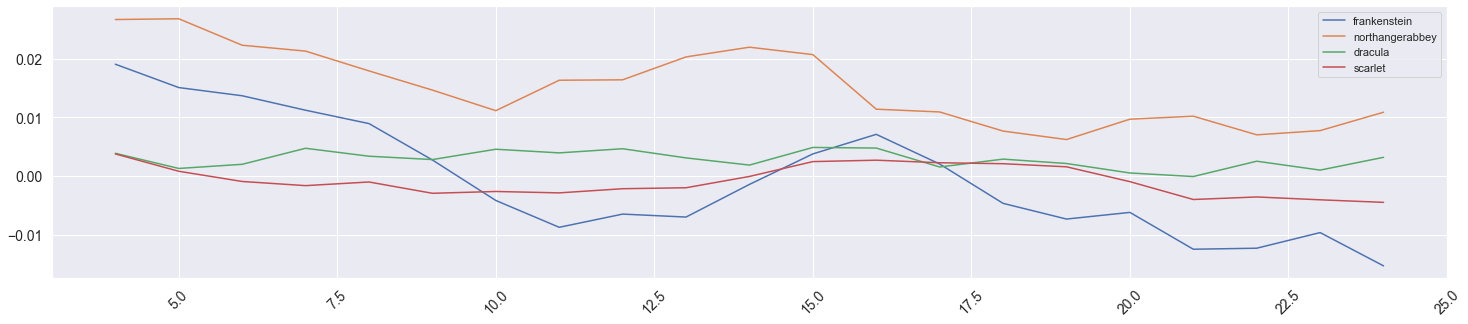

In [148]:
compare_docs(chap_sent, ['frankenstein','northangerabbey', 'dracula', 'scarlet'], 'nrc_polarity', w=5)

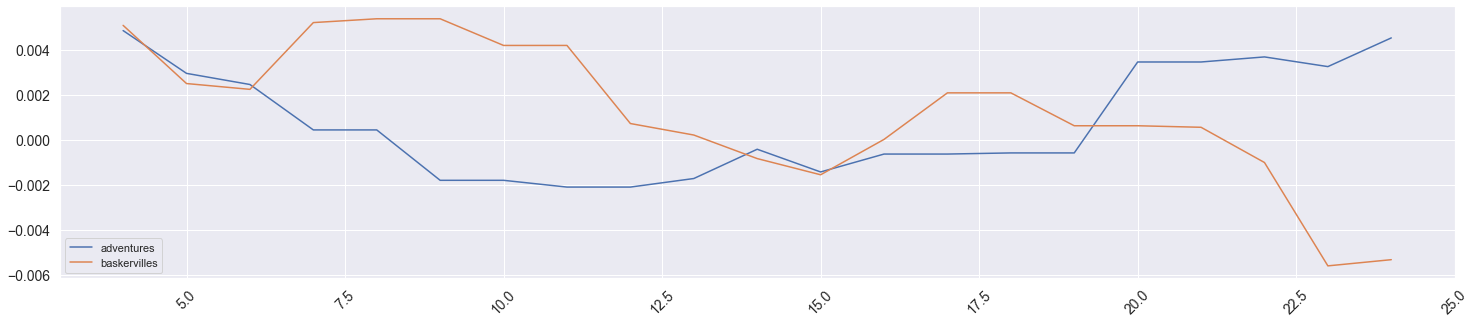

In [150]:
compare_docs(chap_sent, ['adventures','baskervilles'], 'nrc_polarity', w=5)

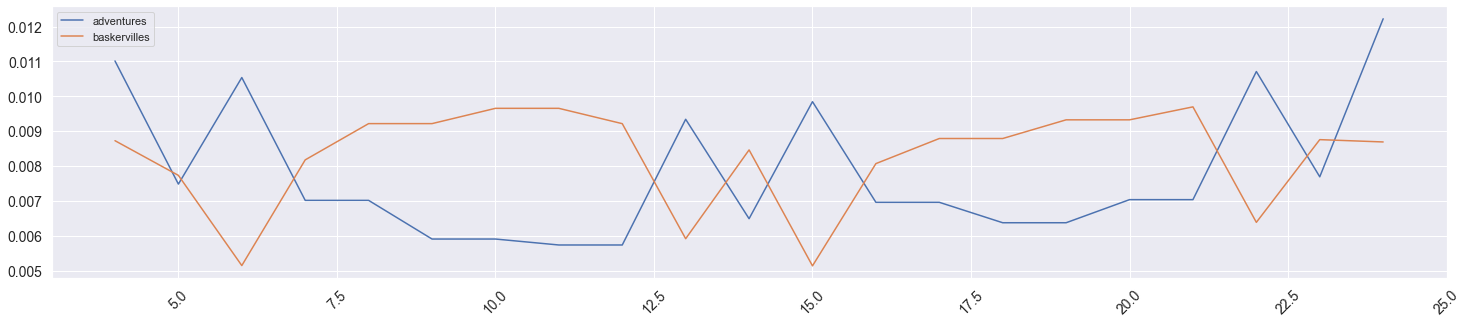

In [151]:
compare_docs(chap_sent, ['adventures','baskervilles'], 'nrc_joy', w=5)

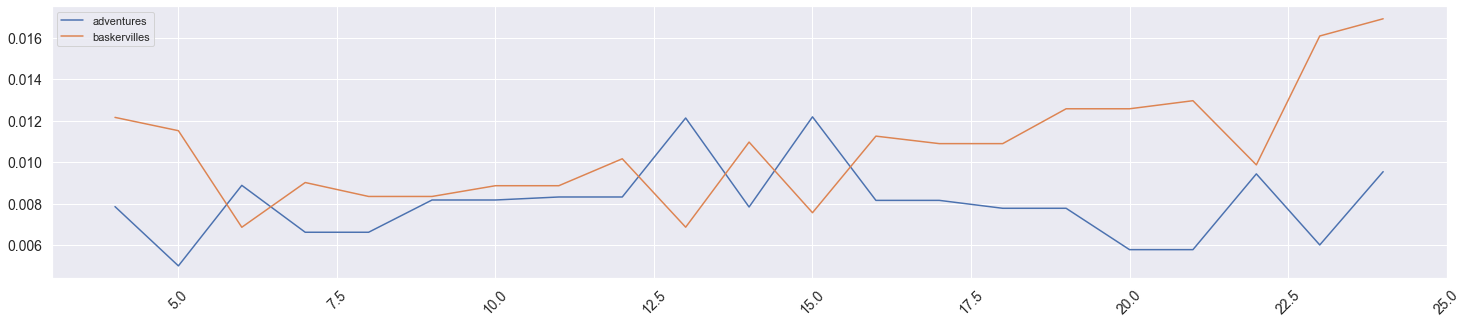

In [152]:
compare_docs(chap_sent, ['adventures','baskervilles'], 'nrc_fear', w=5)

## Method A: COMBO Method

Join SALEX and BOW and then peform computations.

In [90]:
OHCO

['book_id', 'chap_id', 'para_num', 'sent_num', 'token_num']

In [91]:
bag = OHCO[:-1]
BOW = TOKENS.value_counts(bag+['term_str']).to_frame('n').sort_index()
BOW['tf'] = BOW.groupby(bag).n.apply(lambda x: x / x.sum())
BOW.columns = pd.MultiIndex.from_product([['stats'], list(BOW.columns)])

In [157]:
SALEX_ALL = pd.read_csv('../data/salex/salex_combo.csv').set_index('term_str')
SALEX_ALL = SALEX_ALL[~SALEX_ALL.index.duplicated()] # There are 2 instances of 'naive'
assert SALEX_ALL.index.is_unique
SALEX_ALL.columns = pd.MultiIndex.from_product([['sents'], list(SALEX_ALL.columns)])

In [158]:
COMBO = BOW.join(SALEX_ALL)

In [159]:
COMBO

stats               sents  \
                                                   n        tf nrc_anger   
book_id    chap_id para_num sent_num term_str                              
adventures 1       0        1        a             1  0.250000       NaN   
                                     bohemia       1  0.250000       NaN   
                                     in            1  0.250000       NaN   
                                     scandal       1  0.250000       0.0   
                   1        0        i             1  1.000000       NaN   
...                                              ...       ...       ...   
usher      1       47       4        was           1  0.013699       NaN   
                                     waters        1  0.013699       NaN   
                                     while         1  0.013699       NaN   
                                     whirlwind     1  0.013699       0.0   
                                     widened       1  0.013699       NaN   

                                                                             \
                                               nrc_anticipation nrc_disgust   
book_id    chap_id para_num sent_num term_str                                 
adventures 1       0        1        a                      NaN         NaN   
                                     bohemia                NaN         NaN   
                                     in                     NaN         NaN   
                                     scandal                0.0         0.0   
                   1        0        i                      NaN         NaN   
...                                                         ...         ...   
usher      1       47       4        was                    NaN         NaN   
                                     waters                 NaN         NaN   
                                     while                  NaN         NaN   
                                     whirlwind              0.0         0.0   
                                     widened                NaN         NaN   

                                                                              \
                                               nrc_fear nrc_joy nrc_negative   
book_id    chap_id para_num sent_num term_str                                  
adventures 1       0        1        a              NaN     NaN          NaN   
                                     bohemia        NaN     NaN          NaN   
                                     in             NaN     NaN          NaN   
                                     scandal        1.0     0.0          1.0   
                   1        0        i              NaN     NaN          NaN   
...                                                 ...     ...          ...   
usher      1       47       4        was            NaN     NaN          NaN   
                                     waters         NaN     NaN          NaN   
                                     while          NaN     NaN          NaN   
                                     whirlwind      1.0     0.0          1.0   
                                     widened        NaN     NaN          NaN   

                                                                         \
                                               nrc_positive nrc_sadness   
book_id    chap_id para_num sent_num term_str                             
adventures 1       0        1        a                  NaN         NaN   
                                     bohemia            NaN         NaN   
                                     in                 NaN         NaN   
                                     scandal            0.0         0.0   
                   1        0        i                  NaN         NaN   
...                                                     ...         ...   
usher      1       47       4        was                NaN         NaN   
    

In [160]:
A_sent = COMBO.sents.groupby(OHCO[:-1]).mean()
A_para = COMBO.sents.groupby(OHCO[:3]).mean()
A_chap = COMBO.sents.groupby(OHCO[:2]).mean()

In [161]:
A_sent

nrc_anger  nrc_anticipation  \
book_id    chap_id para_num sent_num                                
adventures 1       0        1          0.000000               0.0   
                   1        0               NaN               NaN   
                   2        0               NaN               NaN   
                            1               NaN               NaN   
                            2          0.000000               1.0   
...                                         ...               ...   
usher      1       47       0          0.000000               0.0   
                            1          0.666667               0.0   
                            2          0.500000               0.0   
                            3          0.000000               1.0   
                            4          0.600000               0.0   

                                      nrc_disgust  nrc_fear   nrc_joy  \
book_id    chap_id para_num sent_num                                    
adventures 1       0        1                 0.0  1.000000  0.000000   
                   1        0                 NaN       NaN       NaN   
                   2        0                 NaN       NaN       NaN   
                            1                 NaN       NaN       NaN   
                            2                 0.0  0.000000  1.000000   
...                                           ...       ...       ...   
usher      1       47       0                 1.0  1.000000  0.000000   
                            1                 0.0  0.333333  0.333333   
                            2                 0.0  0.500000  0.000000   
                            3                 0.0  0.000000  1.000000   
                            4                 0.2  0.800000  0.200000   

                                      nrc_negative  nrc_positive  nrc_sadness  \
book_id    chap_id para_num sent_num                                            
adventures 1       0        1             1.000000      0.000000          0.0   
                   1        0                  NaN           NaN          NaN   
                   2        0                  NaN           NaN          NaN   
                            1                  NaN           NaN          NaN   
                            2             0.000000      1.000000          0.0   
...                                            ...           ...          ...   
usher      1       47       0             1.000000      0.000000          0.0   
                            1             0.666667      0.333333          0.0   
                            2             1.000000      0.000000          0.5   
                            3             0.000000      1.000000          0.0   
                            4             0.600000      0.400000          0.0   

                                      nrc_surprise  nrc_trust  nrc_polarity  \
book_id    chap_id para_num sent_num                                          
adventures 1       0        1                  0.0   0.000000     -1.000000   
                   1        0                  NaN        NaN           NaN   
                   2        0                  NaN        NaN           NaN   
                            1                  NaN        NaN           NaN   
                            2                  0.0   1.000000      1.000000   
...                                            ...        ...           ...   
usher      1       47       0                  1.0   0.000000     -1.000000   
                            1                  0.0   0.333333     -0.333333   
                            2                  1.0   0.000000     -1.000000   
                            3                  0.0   1.000000      1.000000   
                            4                  0.0   0.400000     -0.200000   

                                      bing_negative  bing_positive  \
book_id    chap_id para_num sent_num  

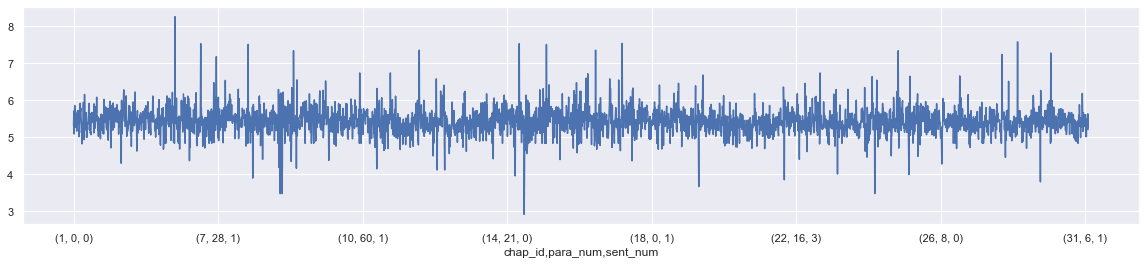

In [162]:
A_sent.T.northangerabbey.T.labmt_happiness.plot(figsize=(20,4));

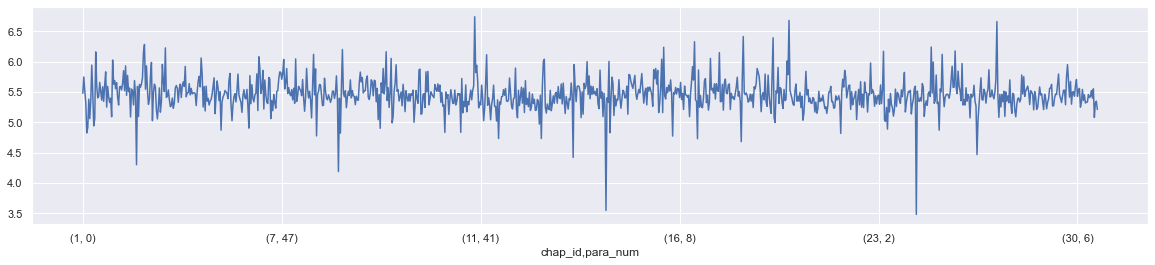

In [163]:
A_para.T.northangerabbey.T.labmt_happiness.plot(figsize=(20,4));

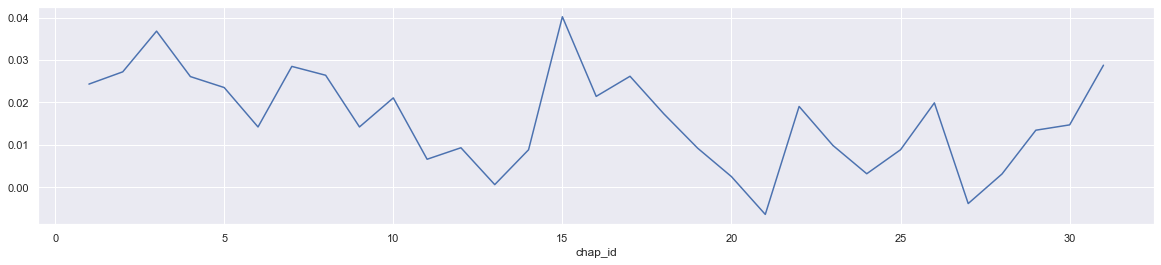

In [167]:
chap_sent.DOC.sents.T.northangerabbey.T.nrc_polarity.plot(figsize=(20, 4));

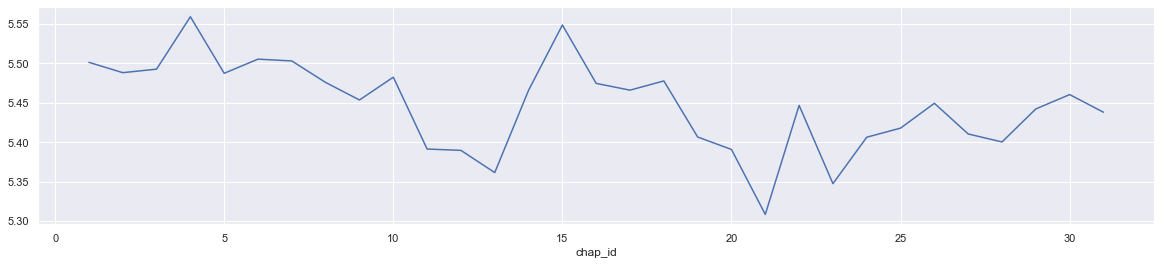

In [168]:
A_chap.T.northangerabbey.T.labmt_happiness.plot(figsize=(20,4));

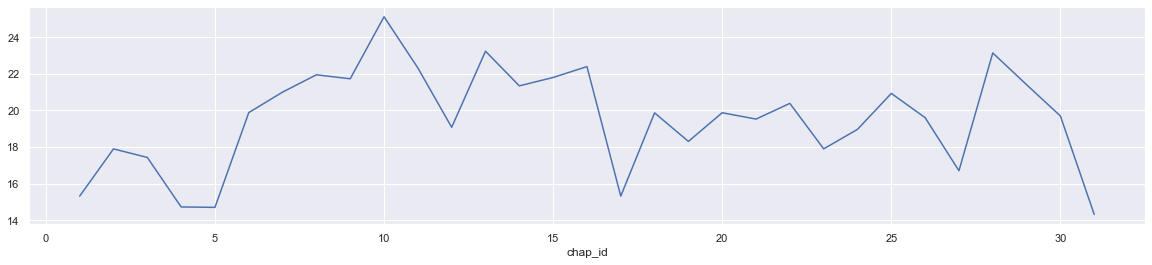

In [122]:
chap_sent.DOC.sents2.T.northangerabbey.T.labmt_happiness.plot(figsize=(20,4));

In [126]:
chap_sent.DOC.sents2

nrc_anger  nrc_anticipation  nrc_disgust  nrc_fear  \
book_id    chap_id                                                       
adventures 1         0.285714          0.544402     0.231660  0.474903   
           2         0.285714          0.552124     0.231660  0.401544   
           3         0.357143          0.585714     0.266667  0.457143   
           4         0.526316          0.511278     0.338346  0.706767   
           5         0.453061          0.436735     0.297959  0.644898   
...                       ...               ...          ...       ...   
udolpho    54        0.424710          0.490347     0.332046  0.594595   
           55        0.500000          0.453704     0.439815  0.648148   
           56        0.276596          0.340426     0.184397  0.425532   
           57        0.197368          0.447368     0.157895  0.171053   
usher      1         0.500000          0.358108     0.361486  0.655405   

                     nrc_joy  nrc_negative  nrc_positive  nrc_sadness  \
book_id    chap_id                                                      
adventures 1        0.586873      0.683398      1.000000     0.397683   
           2        0.625483      0.687259      1.046332     0.393822   
           3        0.661905      0.847619      1.004762     0.509524   
           4        0.556391      1.011278      0.921053     0.575188   
           5        0.428571      0.877551      0.681633     0.489796   
...                      ...           ...           ...          ...   
udolpho    54       0.532819      1.007722      0.911197     0.687259   
           55       0.407407      0.986111      0.666667     0.689815   
           56       0.510638      0.780142      0.773050     0.546099   
           57       0.697368      0.302632      0.921053     0.184211   
usher      1        0.449324      1.097973      0.736486     0.648649   

                    nrc_surprise  nrc_trust  nrc_polarity  bing_negative  \
book_id    chap_id                                                         
adventures 1            0.277992   0.791506      0.316602       0.732639   
           2            0.424710   0.853282      0.359073       0.686084   
           3            0.400000   0.942857      0.157143       0.775100   
           4            0.364662   0.691729     -0.090226       0.986667   
           5            0.318367   0.534694     -0.195918       0.860000   
...                          ...        ...           ...            ...   
udolpho    54           0.324324   0.698842     -0.096525       0.922222   
           55           0.277778   0.462963     -0.319444       1.022422   
           56           0.198582   0.560284     -0.007092       0.745455   
           57           0.184211   0.631579      0.618421       0.342857   
usher      1            0.287162   0.570946     -0.361486       1.067935   

                    bing_positive  bing_sentiment  syu_sentiment  \
book_id    chap_id                                                 
adventures 1             0.895833        0.163194       0.201765   
           2             0.941748        0.255663       0.278656   
           3             0.839357        0.064257       0.235542   
           4             0.676667       -0.310000      -0.005598   
           5             0.604000       -0.256000      -0.020659   
...                           ...             ...            ...   
udolpho    54            0.644444       -0.277778      -0.036154   
           55            0.520179       -0.502242      -0.114524   
           56            0.587879       -0.157576       0.022470   
           57            0.828571        0.485714       0.309167   
usher      1             0.578804       -0.489130      -0.155867   

                    gi_sentiment  labmt_happiness   labmt_z  
book_id    chap_id                                           
adventures 1            0.453674        30.134572 -5.532287  
           2            0.589666        32.4631

In [124]:
A_chap

nrc_anger  nrc_anticipation  nrc_disgust  nrc_fear  \
book_id    chap_id                                                       
adventures 1         0.168565          0.318907     0.134396  0.277904   
           2         0.161863          0.314856     0.130820  0.228381   
           3         0.187831          0.317460     0.148148  0.251323   
           4         0.271318          0.263566     0.174419  0.362403   
           5         0.283117          0.275325     0.187013  0.405195   
...                       ...               ...          ...       ...   
udolpho    54        0.224280          0.257202     0.172840  0.310700   
           55        0.299145          0.270655     0.262108  0.387464   
           56        0.177570          0.224299     0.116822  0.275701   
           57        0.168539          0.382022     0.134831  0.146067   
usher      1         0.276515          0.198864     0.200758  0.361742   

                     nrc_joy  nrc_negative  nrc_positive  nrc_sadness  \
book_id    chap_id                                                      
adventures 1        0.343964      0.398633      0.583144     0.227790   
           2        0.356984      0.388027      0.598670     0.223947   
           3        0.359788      0.455026      0.550265     0.269841   
           4        0.286822      0.519380      0.472868     0.294574   
           5        0.267532      0.553247      0.428571     0.309091   
...                      ...           ...           ...          ...   
udolpho    54       0.279835      0.530864      0.477366     0.366255   
           55       0.247863      0.598291      0.404558     0.413105   
           56       0.327103      0.509346      0.495327     0.355140   
           57       0.595506      0.258427      0.775281     0.157303   
usher      1        0.250000      0.607955      0.409091     0.359848   

                    nrc_surprise  nrc_trust  nrc_polarity  bing_negative  \
book_id    chap_id                                                         
adventures 1            0.161731   0.462415      0.184510       0.450431   
           2            0.241685   0.487805      0.210643       0.418838   
           3            0.214286   0.515873      0.095238       0.479899   
           4            0.187984   0.354651     -0.046512       0.593939   
           5            0.200000   0.337662     -0.124675       0.591667   
...                          ...        ...           ...            ...   
udolpho    54           0.170782   0.364198     -0.053498       0.589928   
           55           0.162393   0.279202     -0.193732       0.660767   
           56           0.130841   0.359813     -0.014019       0.562212   
           57           0.157303   0.528090      0.516854       0.296296   
usher      1            0.160985   0.320076     -0.198864       0.648333   

                    bing_positive  bing_sentiment  syu_sentiment  \
book_id    chap_id                                                 
adventures 1             0.549569        0.099138       0.121505   
           2             0.581162        0.162325       0.163979   
           3             0.520101        0.040201       0.144934   
           4             0.406061       -0.187879      -0.002260   
           5             0.408333       -0.183333      -0.016179   
...                           ...             ...            ...   
udolpho    54            0.410072       -0.179856      -0.022905   
           55            0.339233       -0.321534      -0.074266   
           56            0.437788       -0.124424       0.013542   
           57            0.703704        0.407407       0.262409   
usher      1             0.351667       -0.296667      -0.095309   

                    gi_sentiment  labmt_happiness   labmt_z  
book_id    chap_id                                           
adventures 1            0.208396         5.401427 -0.975863  
           2            0.287591         5.4084

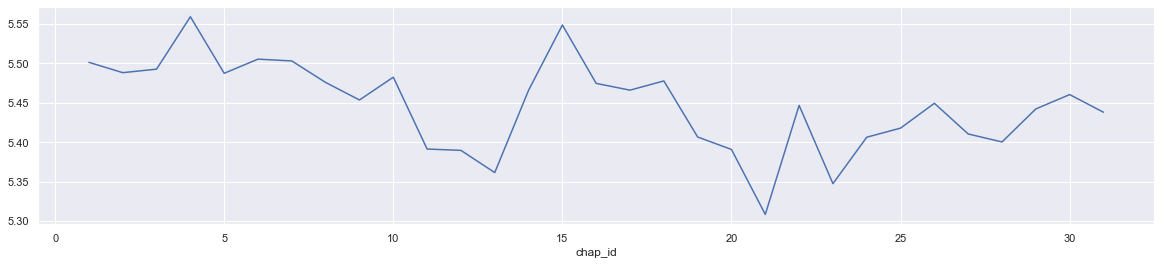

In [347]:
A_chap.T.northangerabbey.T.labmt_happiness.plot(figsize=(20,4));

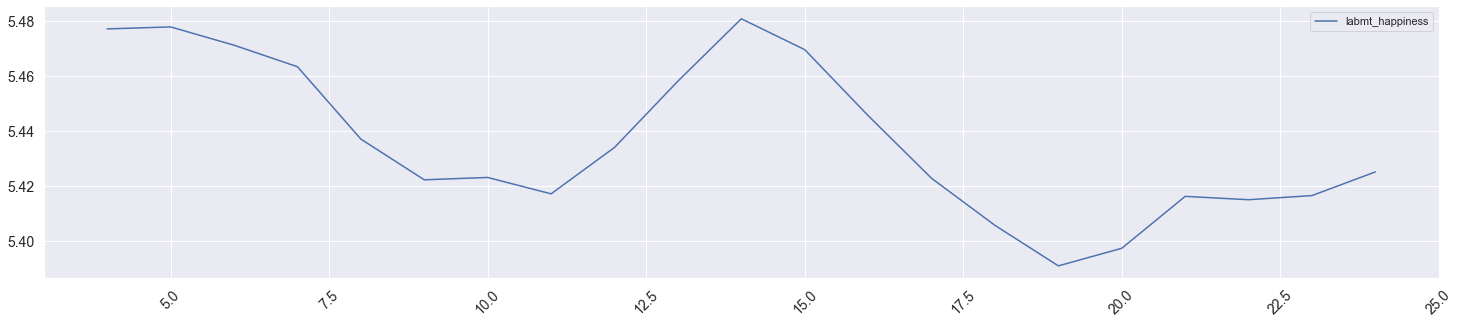

In [358]:
show_rolling(A_sent.T.northangerabbey.T, sent_col='labmt_happiness')

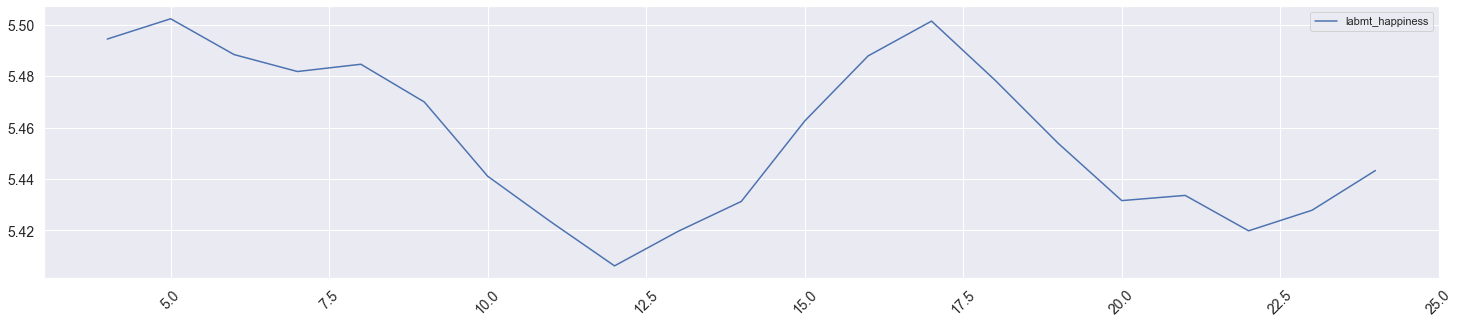

In [359]:
show_rolling(A_para.T.northangerabbey.T, sent_col='labmt_happiness')

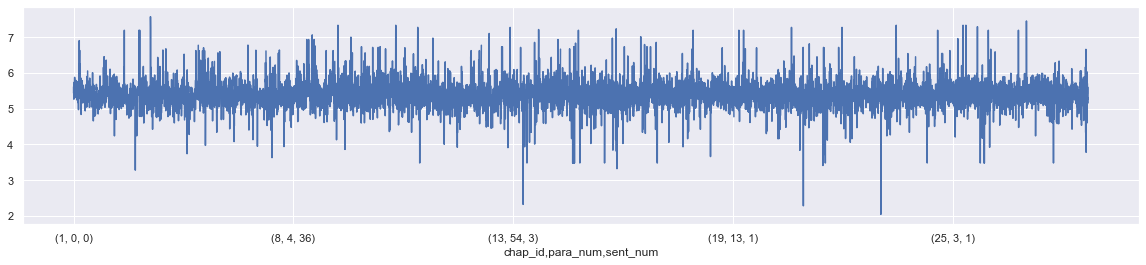

In [307]:
A_sent.T.dracula.T.labmt_happiness.plot(figsize=(20,4));

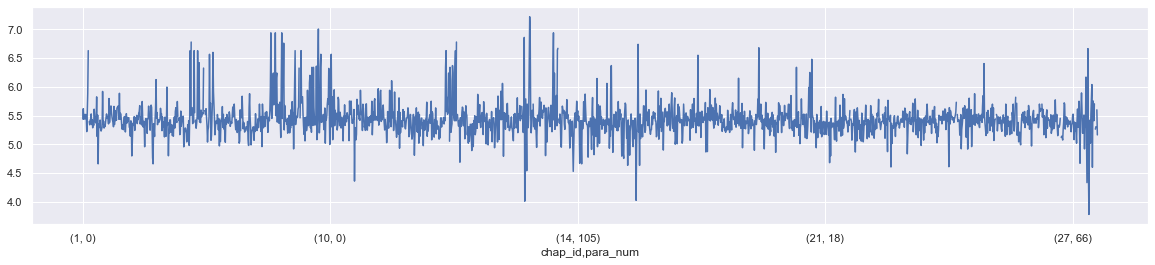

In [309]:
A_para.T.dracula.T.labmt_happiness.plot(figsize=(20,4));

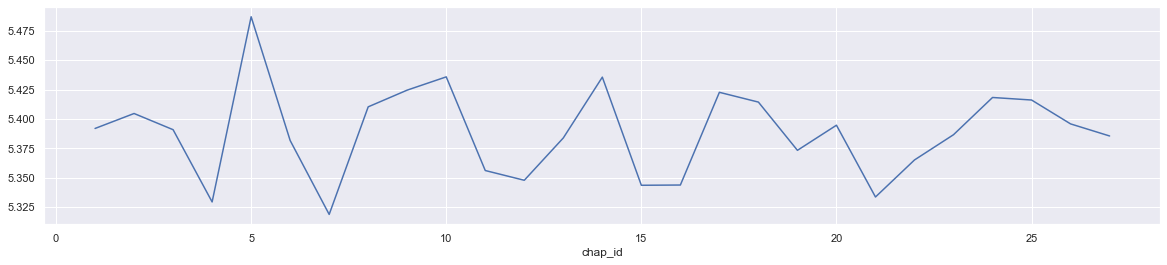

In [348]:
A_chap.T.dracula.T.labmt_happiness.plot(figsize=(20,4));

In [129]:
def show_rolling(df, title='', sent_col='polarity', w=5, cuts=25):
    df = df.reset_index(drop=True).reset_index().rename(columns=dict(index='seq'))
    df['cut'] = pd.cut(df.seq, cuts)
    df = df.groupby('cut')[sent_col].mean().reset_index(drop=True)
    plt = df.fillna(0).rolling(w).mean().plot(figsize=(25, 5), legend=True, fontsize=14, rot=45, title=title)

In [ ]:
show_rolling()

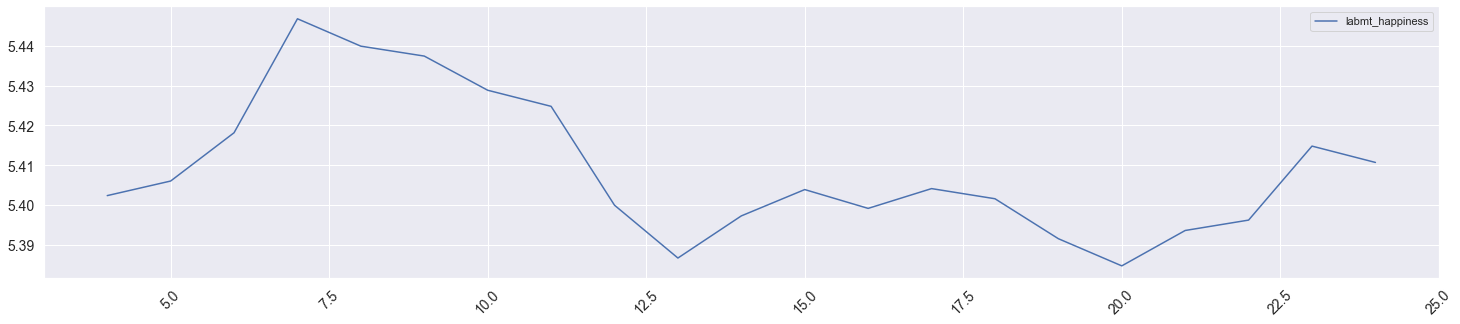

In [130]:
show_rolling(A_sent.T.dracula.T, sent_col='labmt_happiness')

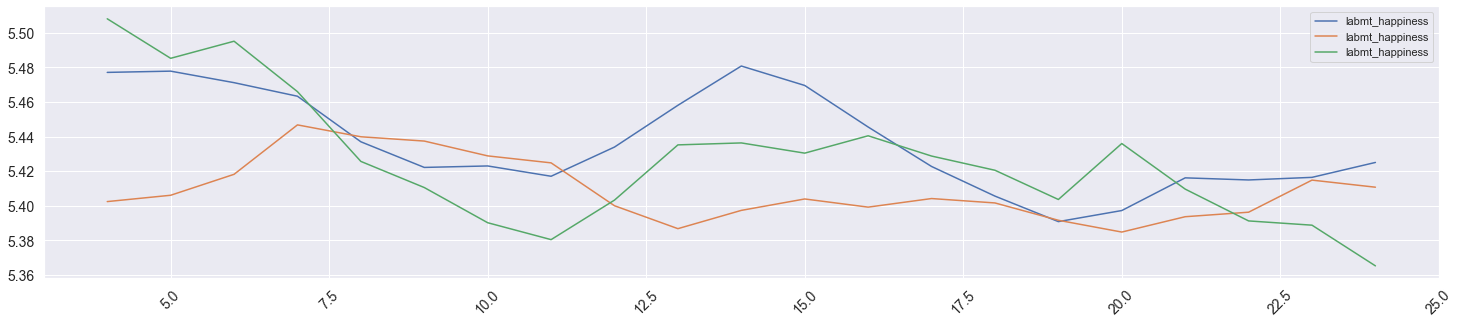

In [306]:
show_rolling(A_sent.T.northangerabbey.T, sent_col='labmt_happiness')
show_rolling(A_sent.T.dracula.T, sent_col='labmt_happiness')
show_rolling(A_sent.T.frankenstein.T, sent_col='labmt_happiness')

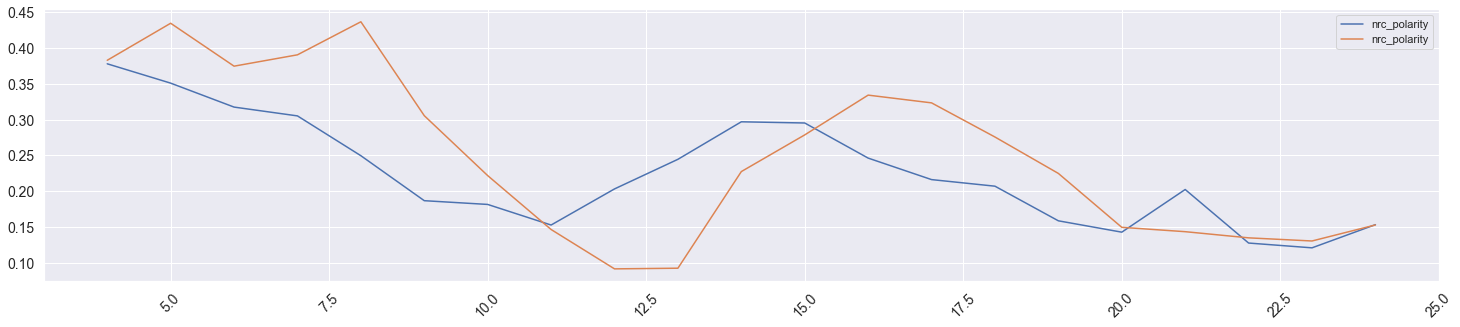

In [660]:
show_rolling(A_sent.T.northangerabbey.T, sent_col='nrc_polarity')
show_rolling(A_para.T.northangerabbey.T, sent_col='nrc_polarity')

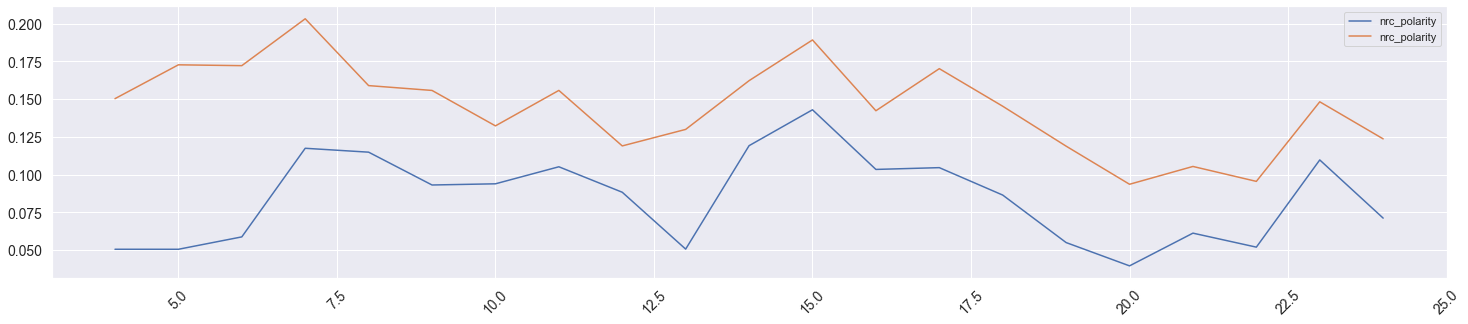

In [659]:
show_rolling(A_sent.T.dracula.T, sent_col='nrc_polarity')
show_rolling(A_para.T.dracula.T, sent_col='nrc_polarity')

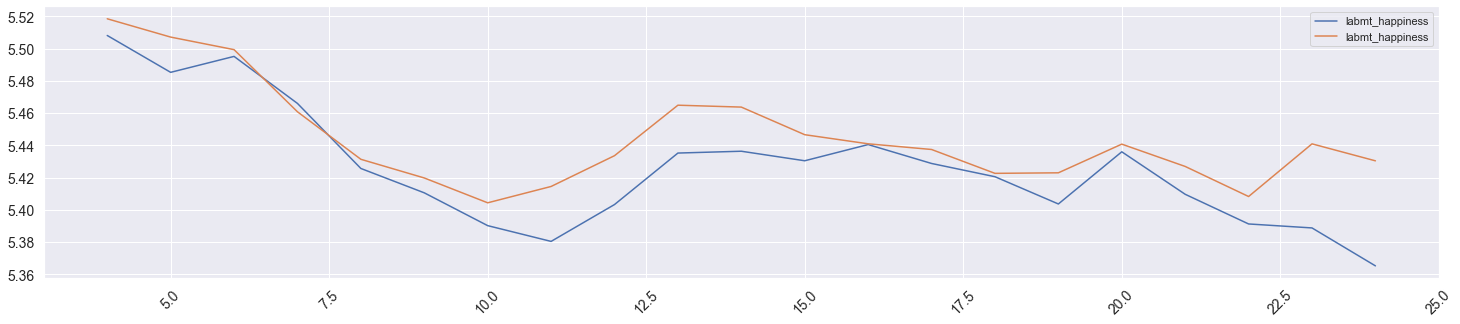

In [305]:
show_rolling(A_sent.T.frankenstein.T, sent_col='labmt_happiness')
show_rolling(A_para.T.frankenstein.T, sent_col='labmt_happiness')

## Method B: Gallagher

1. Bag by level.
2. Compute TF for each term by bag.
3. Multiply TF by Sentiment weight for each term.
4. Sum Sentiment weights by bag.

In [370]:
B_chap = Sentiment(TOKENS, SALEX_ALL.sents)

Extracting VOCAB
Current OHCO level = 1, ['book_id'].


In [371]:
B_chap.ohco_level = 2

In [372]:
B_chap.main()

Extracting BOW
Computing sentiment
nrc_anger nrc_anticipation nrc_disgust nrc_fear nrc_joy nrc_negative nrc_positive nrc_sadness nrc_surprise nrc_trust nrc_polarity bing_negative bing_positive bing_sentiment syu_sentiment gi_sentiment labmt_happiness labmt_z 
Creating DOC
Done


In [398]:
B_para = Sentiment(TOKENS, SALEX_ALL.sents)

Extracting VOCAB
Current OHCO level = 1, ['book_id'].


In [399]:
B_para.ohco_level = 3

In [401]:
# B_para.main()

In [375]:
B_chap.DOC.sents

nrc_anger  nrc_anticipation  nrc_disgust  nrc_fear  \
book_id    chap_id                                                       
adventures 1         0.008597          0.016380     0.006970  0.014289   
           2         0.008046          0.015549     0.006524  0.011308   
           3         0.010684          0.017521     0.007977  0.013675   
           4         0.014455          0.014042     0.009293  0.019411   
           5         0.015071          0.014528     0.009912  0.021453   
...                       ...               ...          ...       ...   
udolpho    54        0.019625          0.022658     0.015343  0.027475   
           55        0.025937          0.023535     0.022815  0.033622   
           56        0.015464          0.019033     0.010309  0.023791   
           57        0.015353          0.034800     0.012282  0.013306   
usher      1         0.020521          0.014698     0.014836  0.026900   

                     nrc_joy  nrc_negative  nrc_positive  nrc_sadness  \
book_id    chap_id                                                      
adventures 1        0.017658      0.020562      0.030088     0.011966   
           2        0.017614      0.019354      0.029466     0.011091   
           3        0.019801      0.025356      0.030057     0.015242   
           4        0.015281      0.027775      0.025297     0.015798   
           5        0.014257      0.029192      0.022675     0.016293   
...                      ...           ...           ...          ...   
udolpho    54       0.024621      0.046566      0.042105     0.031757   
           55       0.021134      0.051153      0.034582     0.035783   
           56       0.028549      0.043616      0.043220     0.030531   
           57       0.054248      0.023541      0.071648     0.014330   
usher      1        0.018441      0.045064      0.030227     0.026622   

                    nrc_surprise  nrc_trust  nrc_polarity  bing_negative  \
book_id    chap_id                                                         
adventures 1            0.008364   0.023815      0.009526       0.024512   
           2            0.011960   0.024030      0.010112       0.023051   
           3            0.011966   0.028205      0.004701       0.027493   
           4            0.010015   0.018998     -0.002478       0.030563   
           5            0.010591   0.017787     -0.006517       0.029192   
...                          ...        ...           ...            ...   
udolpho    54           0.014987   0.032293     -0.004460       0.044425   
           55           0.014409   0.024015     -0.016571       0.054755   
           56           0.011102   0.031324     -0.000397       0.048771   
           57           0.014330   0.049130      0.048106       0.024565   
usher      1            0.011786   0.023433     -0.014836       0.054493   

                    bing_positive  bing_sentiment  syu_sentiment  \
book_id    chap_id                                                 
adventures 1             0.029972        0.005460       0.011954   
           2             0.031641        0.008590       0.015331   
           3             0.029772        0.002279       0.013925   
           4             0.020960       -0.009602      -0.000299   
           5             0.020502       -0.008690      -0.001276   
...                           ...             ...            ...   
udolpho    54            0.031044       -0.013381      -0.002935   
           55            0.027858       -0.026897      -0.010699   
           56            0.038462       -0.010309       0.002201   
           57            0.059365        0.034800       0.037973   
usher      1             0.029534       -0.024958      -0.012708   

                    gi_sentiment  labmt_happiness   labmt_z  
book_id    chap_id                                           
adventures 1            0.016496         4.946579 -0.908123  
           2            0.021094         4.9981

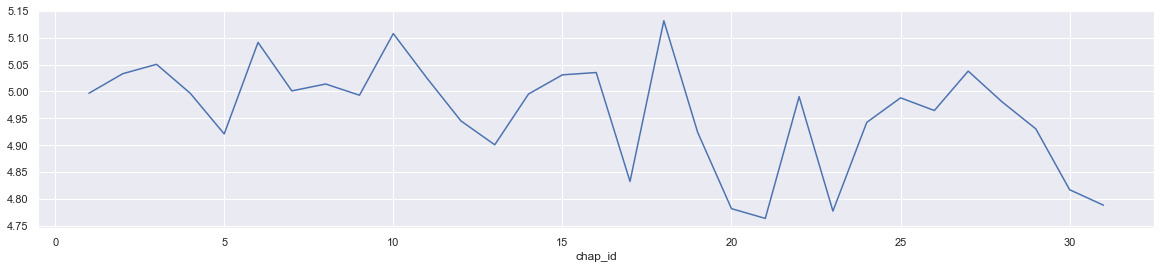

In [394]:
B_chap.DOC.T.northangerabbey.T.sents.labmt_happiness.plot(figsize=(20,4));

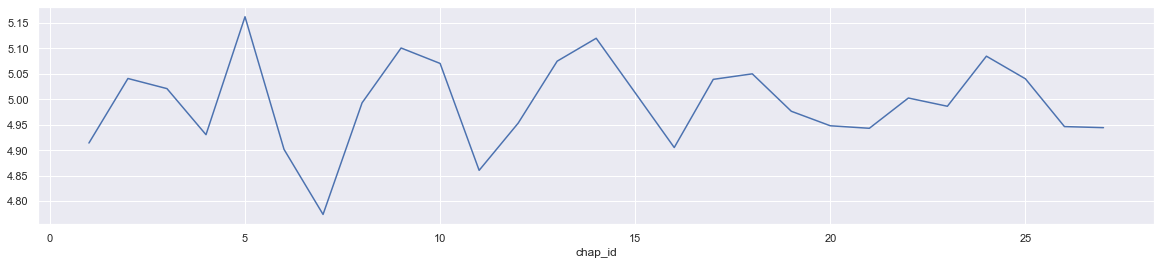

In [391]:
B_chap.DOC.T.dracula.T.sents.labmt_happiness.plot(figsize=(20,4));

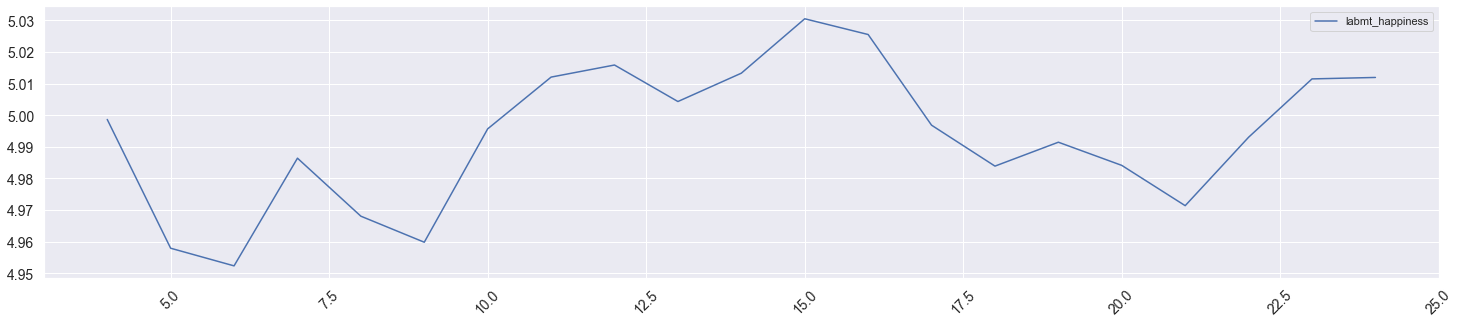

In [392]:
show_rolling(B_chap.DOC.T.dracula.T.sents.labmt_happiness, sent_col='labmt_happiness')

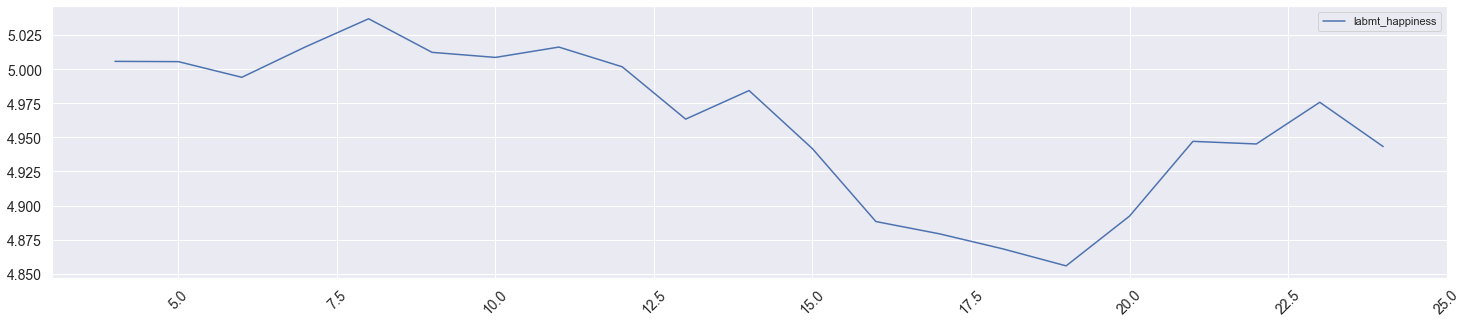

In [393]:
show_rolling(B_chap.DOC.T.northangerabbey.T.sents.labmt_happiness, sent_col='labmt_happiness')

In [ ]:
# B_para.BOW

In [475]:
# (B_chap.DOC.terms * B_chap.SALEX.labmt_happiness).sum(1)

In [450]:
B1_n = BOW.stats.groupby(OHCO[:2]+['term_str']).n.sum().to_frame('n').unstack()
B1_n.columns = B1_n.columns.droplevel(0)

In [451]:
B1_tf = (B1_n.T / B1_n.T.sum()).T

In [487]:
X1 = (B1_tf * SALEX_ALL.sents.labmt_happiness).sum(1)

In [489]:
X2 = (B1_n * SALEX_ALL.sents.nrc_polarity).mean(1)

<AxesSubplot:xlabel='chap_id'>

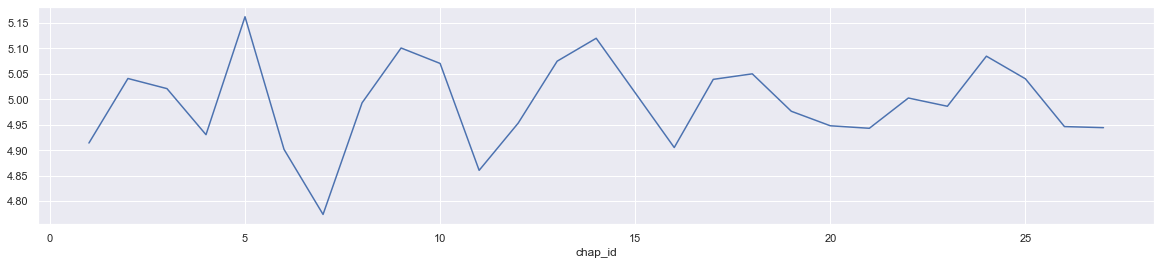

In [490]:
X1.T.dracula.T.plot(figsize=(20,4))

<AxesSubplot:xlabel='chap_id'>

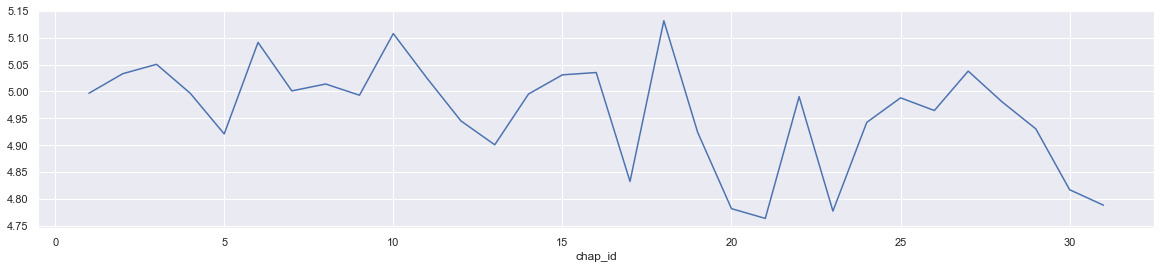

In [491]:
X1.T.northangerabbey.T.plot(figsize=(20,4))

<AxesSubplot:xlabel='chap_id'>

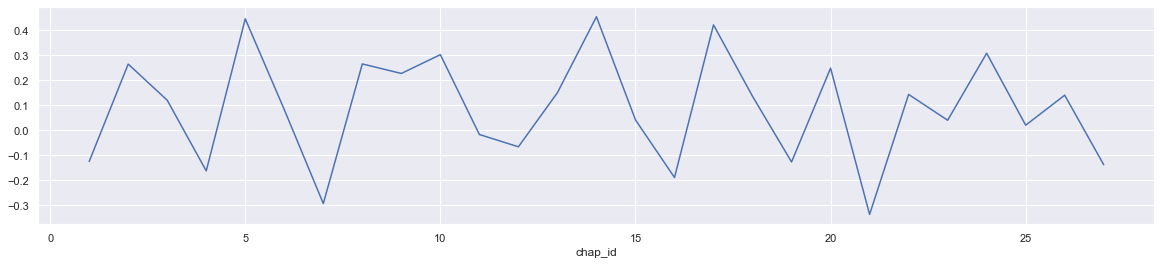

In [492]:
X2.T.dracula.T.plot(figsize=(20,4))

<AxesSubplot:xlabel='chap_id'>

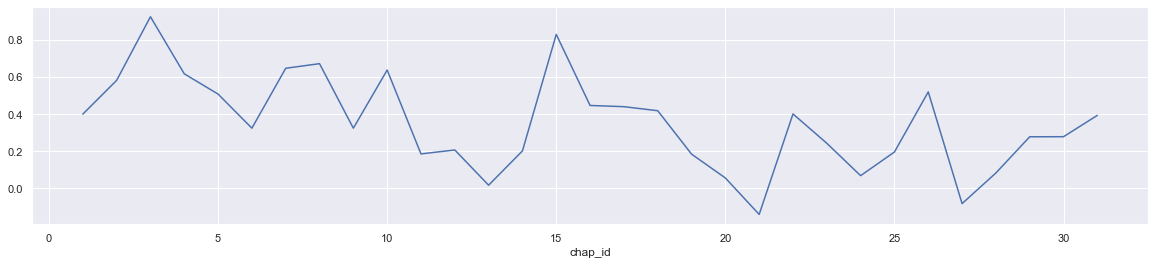

In [493]:
X2.T.northangerabbey.T.plot(figsize=(20,4))

In [136]:
chap_sent.DOC.sents

nrc_anger  nrc_anticipation  nrc_disgust  nrc_fear  \
book_id    chap_id                                                       
adventures 1         0.008597          0.016380     0.006970  0.014289   
           2         0.008046          0.015549     0.006524  0.011308   
           3         0.010684          0.017521     0.007977  0.013675   
           4         0.014455          0.014042     0.009293  0.019411   
           5         0.015071          0.014528     0.009912  0.021453   
...                       ...               ...          ...       ...   
udolpho    54        0.019625          0.022658     0.015343  0.027475   
           55        0.025937          0.023535     0.022815  0.033622   
           56        0.015464          0.019033     0.010309  0.023791   
           57        0.015353          0.034800     0.012282  0.013306   
usher      1         0.020521          0.014698     0.014836  0.026900   

                     nrc_joy  nrc_negative  nrc_positive  nrc_sadness  \
book_id    chap_id                                                      
adventures 1        0.017658      0.020562      0.030088     0.011966   
           2        0.017614      0.019354      0.029466     0.011091   
           3        0.019801      0.025356      0.030057     0.015242   
           4        0.015281      0.027775      0.025297     0.015798   
           5        0.014257      0.029192      0.022675     0.016293   
...                      ...           ...           ...          ...   
udolpho    54       0.024621      0.046566      0.042105     0.031757   
           55       0.021134      0.051153      0.034582     0.035783   
           56       0.028549      0.043616      0.043220     0.030531   
           57       0.054248      0.023541      0.071648     0.014330   
usher      1        0.018441      0.045064      0.030227     0.026622   

                    nrc_surprise  nrc_trust  nrc_polarity  bing_negative  \
book_id    chap_id                                                         
adventures 1            0.008364   0.023815      0.009526       0.024512   
           2            0.011960   0.024030      0.010112       0.023051   
           3            0.011966   0.028205      0.004701       0.027493   
           4            0.010015   0.018998     -0.002478       0.030563   
           5            0.010591   0.017787     -0.006517       0.029192   
...                          ...        ...           ...            ...   
udolpho    54           0.014987   0.032293     -0.004460       0.044425   
           55           0.014409   0.024015     -0.016571       0.054755   
           56           0.011102   0.031324     -0.000397       0.048771   
           57           0.014330   0.049130      0.048106       0.024565   
usher      1            0.011786   0.023433     -0.014836       0.054493   

                    bing_positive  bing_sentiment  syu_sentiment  \
book_id    chap_id                                                 
adventures 1             0.029972        0.005460       0.011954   
           2             0.031641        0.008590       0.015331   
           3             0.029772        0.002279       0.013925   
           4             0.020960       -0.009602      -0.000299   
           5             0.020502       -0.008690      -0.001276   
...                           ...             ...            ...   
udolpho    54            0.031044       -0.013381      -0.002935   
           55            0.027858       -0.026897      -0.010699   
           56            0.038462       -0.010309       0.002201   
           57            0.059365        0.034800       0.037973   
usher      1             0.029534       -0.024958      -0.012708   

                    gi_sentiment  labmt_happiness   labmt_z  
book_id    chap_id                                           
adventures 1            0.016496         4.946579 -0.908123  
           2            0.021094         4.9981

In [134]:
A_chap

nrc_anger  nrc_anticipation  nrc_disgust  nrc_fear  \
book_id    chap_id                                                       
adventures 1         0.168565          0.318907     0.134396  0.277904   
           2         0.161863          0.314856     0.130820  0.228381   
           3         0.187831          0.317460     0.148148  0.251323   
           4         0.271318          0.263566     0.174419  0.362403   
           5         0.283117          0.275325     0.187013  0.405195   
...                       ...               ...          ...       ...   
udolpho    54        0.224280          0.257202     0.172840  0.310700   
           55        0.299145          0.270655     0.262108  0.387464   
           56        0.177570          0.224299     0.116822  0.275701   
           57        0.168539          0.382022     0.134831  0.146067   
usher      1         0.276515          0.198864     0.200758  0.361742   

                     nrc_joy  nrc_negative  nrc_positive  nrc_sadness  \
book_id    chap_id                                                      
adventures 1        0.343964      0.398633      0.583144     0.227790   
           2        0.356984      0.388027      0.598670     0.223947   
           3        0.359788      0.455026      0.550265     0.269841   
           4        0.286822      0.519380      0.472868     0.294574   
           5        0.267532      0.553247      0.428571     0.309091   
...                      ...           ...           ...          ...   
udolpho    54       0.279835      0.530864      0.477366     0.366255   
           55       0.247863      0.598291      0.404558     0.413105   
           56       0.327103      0.509346      0.495327     0.355140   
           57       0.595506      0.258427      0.775281     0.157303   
usher      1        0.250000      0.607955      0.409091     0.359848   

                    nrc_surprise  nrc_trust  nrc_polarity  bing_negative  \
book_id    chap_id                                                         
adventures 1            0.161731   0.462415      0.184510       0.450431   
           2            0.241685   0.487805      0.210643       0.418838   
           3            0.214286   0.515873      0.095238       0.479899   
           4            0.187984   0.354651     -0.046512       0.593939   
           5            0.200000   0.337662     -0.124675       0.591667   
...                          ...        ...           ...            ...   
udolpho    54           0.170782   0.364198     -0.053498       0.589928   
           55           0.162393   0.279202     -0.193732       0.660767   
           56           0.130841   0.359813     -0.014019       0.562212   
           57           0.157303   0.528090      0.516854       0.296296   
usher      1            0.160985   0.320076     -0.198864       0.648333   

                    bing_positive  bing_sentiment  syu_sentiment  \
book_id    chap_id                                                 
adventures 1             0.549569        0.099138       0.121505   
           2             0.581162        0.162325       0.163979   
           3             0.520101        0.040201       0.144934   
           4             0.406061       -0.187879      -0.002260   
           5             0.408333       -0.183333      -0.016179   
...                           ...             ...            ...   
udolpho    54            0.410072       -0.179856      -0.022905   
           55            0.339233       -0.321534      -0.074266   
           56            0.437788       -0.124424       0.013542   
           57            0.703704        0.407407       0.262409   
usher      1             0.351667       -0.296667      -0.095309   

                    gi_sentiment  labmt_happiness   labmt_z  
book_id    chap_id                                           
adventures 1            0.208396         5.401427 -0.975863  
           2            0.287591         5.4084